# setup

In [2]:
import datetime
import json
import os
import time
from collections import Counter, defaultdict

import seaborn as sns
import matplotlib.pyplot as plt
import nltk
import pandas as pd
import numpy as np
import praw
import urllib3.exceptions
from dotenv import load_dotenv
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from praw.models import MoreComments
from prawcore.exceptions import RequestException, ResponseException, ServerError
from tqdm import tqdm
from wordcloud import WordCloud
import string

In [3]:
# Download NLTK data
nltk.download('stopwords')
nltk.download('punkt')

# Load stop words
STOPWORDS = set(stopwords.words('english'))
PUNCTUATION = set(string.punctuation)

[nltk_data] Downloading package stopwords to C:\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to C:\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


## Change parameters here

In [4]:
# CHANGE HERE: maximum subreddit/posts/comments to retrieve
# max: 100 based on the documentation
LIMIT_SUBREDDITS_PER_KEYWORD = 100 # max subreddits per keyword
LIMIT_POSTS = 10
LIMIT_COMMENTS = 10
POSTS_TIME_FILTER = "year" # all/day/hour/month/week/year

# Feel free to modify these files to suit your needs
KEYWORD_FILE = '../ai_keywords.txt'

# Progress files
SUBREDDITS_PROGRESS_FILE = 'progress_subreddits.json'
POSTS_PROGRESS_FILE = 'posts_progress.json'
COMMENTS_PROGRESS_FILE = 'comments_progress.json'

# Output files
SUBREDDITS_FILE = 'subreddits.json'
POSTS_FILE = 'posts.json'
COMMENTS_FILE = 'comments.json'

# Date of ChatGPT release
CHATGPT_RELEASE_DATE = datetime.datetime(2022, 11, 30).timestamp()

INITIAL_WAIT_TIME = 240
MAX_RETRIES = 5

# Setup reddit credentials

In [5]:
from pprint import pprint

load_dotenv()
reddit_info = {
    "username": os.getenv("REDDIT_USERNAME"),
    "password": os.getenv("REDDIT_PASSWORD"),
    "personal_use_script": os.getenv("REDDIT_PERSONAL_USE_SCRIPT"),
    "secret": os.getenv("REDDIT_SECRET"),
    "user_agent": os.getenv("REDDIT_USER_AGENT"),
}
pprint(reddit_info)

{'password': 'm2229@t05',
 'personal_use_script': '0Fvnl3H9BuS0YgA20mqw4Q',
 'secret': 'qIhF7rM2xZCu1qHf2cbIBrxenajPGQ',
 'user_agent': 'muehuhu:user',
 'username': 'muehuhu'}


In [6]:
# https://praw.readthedocs.io/en/stable/getting_started/quick_start.html

reddit = praw.Reddit(
    username=reddit_info["username"],
    password=reddit_info["password"],
    client_id=reddit_info["personal_use_script"],
    client_secret=reddit_info["secret"],
    user_agent=reddit_info["user_agent"],
)

print(reddit.read_only)
# Output: False

False


# searching for subreddits

### for exception handling

In [7]:
# Function to handle retries with exponential backoff
def retry_on_failure(func, max_retries=5, initial_delay=1, backoff_factor=2, *args, **kwargs):
    retries = 0
    delay = initial_delay
    while retries < max_retries:
        try:
            return func(*args, **kwargs)
        except (RequestException, ResponseException, ServerError, urllib3.exceptions.NewConnectionError) as e:
            print(f"Error occurred: {e}. Retrying in {delay} seconds...")
            time.sleep(delay)
            delay *= backoff_factor
            retries += 1
    raise Exception(f"Max retries exceeded for function: {func.__name__}")

### methods

#### get subreddit

In [16]:
# Function to get subreddits
def get_subreddits(keywords, limit_subreddits=5, progress_file=SUBREDDITS_PROGRESS_FILE):
    subreddits_by_keyword = {}
    subreddits = []

    # Load progress from file if it exists
    try:
        with open(progress_file, 'r') as f:
            progress = json.load(f)
    except FileNotFoundError:
        progress = {}

    try:
        for keyword in tqdm(keywords, desc="retrieving subreddit names"):
            if keyword not in progress:
                progress[keyword] = {'processed': False}

            if progress[keyword]['processed']:
                continue

            results = reddit.subreddits.search(keyword, limit=limit_subreddits)
            subreddits_by_keyword[keyword] = []
            for result in results:
                if result.display_name not in subreddits:
                    subreddits.append(result.display_name)
                subreddits_by_keyword[keyword].append(result.display_name)

            progress[keyword]['processed'] = True

            # Save progress in the loop
            with open(progress_file, 'w') as f:
                json.dump(progress, f)

    except Exception as e:
        print(f"An error occurred: {e}")

        # Save progress if an error occurs
        with open(progress_file, 'w') as f:
            json.dump(progress, f)

    return subreddits_by_keyword


#### get top posts and comments v3

In [7]:
def load_existing_data(file_path):
    try:
        with open(file_path, 'r', encoding='utf-8') as f:
            return json.load(f)
    except FileNotFoundError:
        return {}

def save_data(file_path, data):
    with open(file_path, 'w', encoding='utf-8') as f:
        json.dump(data, f, indent=4)

def get_top_posts_and_comments(subreddits, limit_posts=10, limit_comments=10, initial_wait_time=INITIAL_WAIT_TIME, max_retries=MAX_RETRIES):
    posts_data = load_existing_data(POSTS_FILE)
    comments_data = load_existing_data(COMMENTS_FILE)

    # Load posts progress from file if it exists
    try:
        with open(POSTS_PROGRESS_FILE, 'r') as f:
            posts_progress = json.load(f)
    except FileNotFoundError:
        posts_progress = {}

    try:
        for subreddit in tqdm(subreddits, desc="Fetching posts and comments"):
            if subreddit in posts_progress and posts_progress[subreddit]['processed']:
                continue

            subreddit_posts = []
            subreddit_comments = []

            # Fetch top posts with retry logic
            for attempt in range(max_retries):
                try:
                    # Get top posts
                    print('calling api for subreddit:' + subreddit)
                    for submission in reddit.subreddit(subreddit).top('year', limit=limit_posts):
                        post_info = {
                            'id': submission.id,
                            'title': submission.title,
                            'score': submission.score,
                            'url': submission.url,
                            'num_comments': submission.num_comments
                        }
                        subreddit_posts.append(post_info)

                        # Fetch top comments
                        submission.comments.replace_more(limit=0)
                        post_comments = []
                        for comment in submission.comments.list()[:limit_comments]:
                            if isinstance(comment, praw.models.MoreComments):
                                continue
                            comment_info = {
                                'id': comment.id,
                                'body': comment.body,
                                'score': comment.score
                            }
                            post_comments.append(comment_info)

                        subreddit_comments.append({submission.id: post_comments})

                    break  # Break if successful
                except Exception as e:
                    print(f"An error occurred while calling api: {e}")
                    if attempt < max_retries - 1:
                        wait_time = initial_wait_time * (2 ** attempt)
                        print(f"Retrying in {wait_time} seconds...")
                        time.sleep(wait_time)
                    else:
                        print("Max retries exceeded, saving progress and exiting...")
                        raise

            # Append new data to the existing data
            if subreddit not in posts_data:
                posts_data[subreddit] = []
            posts_data[subreddit].extend(subreddit_posts)

            if subreddit not in comments_data:
                comments_data[subreddit] = []
            comments_data[subreddit].extend(subreddit_comments)

            posts_progress[subreddit] = {'processed': True}

            # Save progress and data in the loop
            save_data(POSTS_PROGRESS_FILE, posts_progress)
            save_data(POSTS_FILE, posts_data)
            save_data(COMMENTS_FILE, comments_data)

    except Exception as e:
        print(f"An error occurred, saving data: {e}")

        # Save progress and data if an error occurs
        save_data(POSTS_PROGRESS_FILE, posts_progress)
        save_data(POSTS_FILE, posts_data)
        save_data(COMMENTS_FILE, comments_data)

    return posts_data, comments_data

### running - retrieve keywords from file

In [12]:
# retrieves relevant keywords from file
keywords = []
with open(KEYWORD_FILE, 'r', encoding='utf-8') as keywordstxt:
    keywords = [line.rstrip('\n') for line in keywordstxt]
pprint(keywords)


['Open Source',
 'License',
 'GitHub',
 'Artificial Intelligence',
 'LLama',
 'AI',
 'Machine Learning',
 'ML',
 'Large Language Models',
 'LLM',
 'Chatbot',
 'OpenAI',
 'ChatGPT',
 'DALL-E',
 'GPT',
 'Prompt',
 'Generative AI']


### running - get relevant subreddits

#### calling api and storing subreddit lists in a file - NOTE: don't forget to remove progress files after finishing

In [30]:
# Get subreddits and their counts
reoloaded_subreddits_by_keyword = get_subreddits(keywords, limit_subreddits=LIMIT_SUBREDDITS_PER_KEYWORD)
print("Subreddit counts by keyword before saving to file:")
pprint(reoloaded_subreddits_by_keyword)

# Output the dictionary to a JSON file
with open(SUBREDDITS_FILE, 'w', encoding='utf-8') as f:
    json.dump(reoloaded_subreddits_by_keyword, f, indent=4)

print("Subreddits by keyword saved to JSON file.")

NameError: name 'get_subreddits' is not defined

#### reloading

In [8]:
# Reload subreddit names from the JSON file after optional inspections/edits
with open(SUBREDDITS_FILE, 'r', encoding='utf-8') as f:
    reloaded_subreddits_by_keyword = json.load(f)

print("Subreddit counts by keyword after reloading from file:")
pprint(reloaded_subreddits_by_keyword)


Subreddit counts by keyword after reloading from file:
{'AI': ['artificial',
        'ChatGPT',
        'singularity',
        'technology',
        'ArtificialInteligence',
        'Futurology',
        'MachineLearning',
        'OpenAI',
        'replika',
        'StableDiffusion',
        'ProgrammerHumor',
        'ClaudeAI',
        'PygmalionAI',
        'SillyTavernAI',
        'perplexity_ai'],
 'Artificial Intelligence': ['artificial',
                             'ArtificialInteligence',
                             'Futurology',
                             'singularity',
                             'technology',
                             'MachineLearning',
                             'agi',
                             'AIethics',
                             'automation',
                             'OpenAI',
                             'programming',
                             'intelligenceagents',
                             'compsci',
                       

### running - get top posts and comments v2

In [9]:
# Assuming subreddits_by_keyword is already loaded or fetched
subreddits = list(reloaded_subreddits_by_keyword.values())

# Flatten the list of subreddits
flattened_subreddits = [item for sublist in subreddits for item in sublist]

# Get posts and comments with retry mechanism
posts_data, comments_data = get_top_posts_and_comments(flattened_subreddits, limit_posts=10, limit_comments=10, initial_wait_time=INITIAL_WAIT_TIME, max_retries=MAX_RETRIES)

print("Posts and comments data saved to JSON files.")


Fetching posts and comments:   0%|          | 0/318 [00:00<?, ?it/s]C:\Users\prach\AppData\Local\Temp\ipykernel_22184\83863643.py:34: DeprecationWarning: Positional arguments for 'BaseListingMixin.top' will no longer be supported in PRAW 8.
Call this function with 'time_filter' as a keyword argument.
  for submission in reddit.subreddit(subreddit).top('year', limit=limit_posts):
Fetching posts and comments:  42%|████▏     | 132/318 [00:01<00:02, 79.38it/s]

An error occurred while calling api: received 403 HTTP response
An error occurred, saving data: local variable 'submission' referenced before assignment
Posts and comments data saved to JSON files.


# data analysis

## preprocess text data

In [20]:
def preprocess_text(text):
    # Tokenize the text
    tokens = word_tokenize(text.lower())
    # Remove stop words and punctuation
    filtered_tokens = [token for token in tokens if token not in STOPWORDS and token not in PUNCTUATION]
    return filtered_tokens

def get_all_text(posts_data, comments_data):
    all_text = []
    for subreddit, posts in posts_data.items():
        for post in posts:
            all_text.extend(preprocess_text(post['title']))
            post_id = post['id']
            for comment in comments_data.get(subreddit, []):
                if post_id in comment:
                    for comm in comment[post_id]:
                        all_text.extend(preprocess_text(comm['body']))
    return all_text

all_text = get_all_text(posts_data, comments_data)

## build co-occurence matrix

In [21]:
def build_cooccurrence_matrix(tokens, window_size=2):
    cooccurrence = defaultdict(Counter)
    for i, token in enumerate(tokens):
        for j in range(max(0, i - window_size), min(len(tokens), i + window_size + 1)):
            if i != j:
                cooccurrence[token][tokens[j]] += 1
    return cooccurrence

cooccurrence_matrix = build_cooccurrence_matrix(all_text)


## visualize

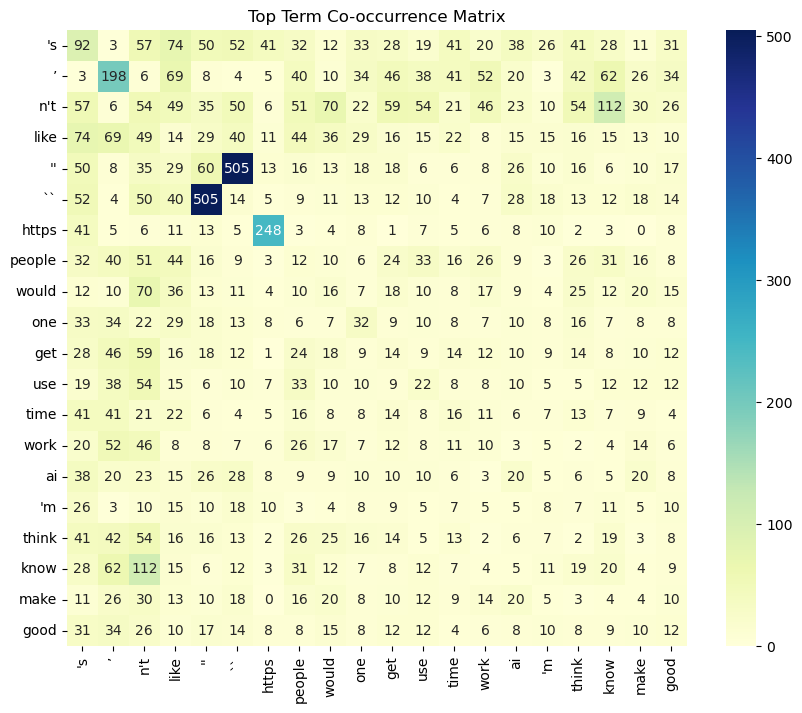

In [22]:
def plot_cooccurrence_matrix(cooccurrence_matrix, top_k=20):
    top_terms = Counter({term: sum(context.values()) for term, context in cooccurrence_matrix.items()}).most_common(top_k)
    terms = [term for term, count in top_terms]

    matrix = np.zeros((top_k, top_k))
    for i, term1 in enumerate(terms):
        for j, term2 in enumerate(terms):
            matrix[i, j] = cooccurrence_matrix[term1][term2]

    plt.figure(figsize=(10, 8))
    sns.heatmap(matrix, xticklabels=terms, yticklabels=terms, cmap="YlGnBu", annot=True, fmt="g")
    plt.title("Top Term Co-occurrence Matrix")
    plt.show()

plot_cooccurrence_matrix(cooccurrence_matrix)
